# InSituPy demonstration - Differential gene expression analysis

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import read_xenium
import scanpy as sc

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Xenium data into `InSituData` object

Now the Xenium data can be parsed by providing the data path to the `InSituPy` project folder.

In [4]:
insitupy_project = Path("demo_dataset/demo_insitupy_project")

In [5]:
xd = read_xenium(insitupy_project)

In [6]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy

In [7]:
xd.load_images()
xd.load_cells()

Loading images...
Loading cells...
	No alternative cells found...


In [8]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       DAPI:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 163565 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'annotations-TestKey', 'annotations-demo', 'annotations-demo2', 'annotations-demo3', 'cell_type'
           var: 'gene_ids', 'feature_types', 'genome'
           uns: 'cell_type_colors', 'counts_location', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
           obsm: 'OT', 'X_pca', 'X_umap', 'spatial'
           varm: 'OT', 'PCs', 'binned_expression'
           layers: 'counts', 'norm_counts'
           obsp: 'connec

In [9]:
xd.import_annotations(
    files="./demo_annotations/annotations-Tumor.geojson",
    keys="Tumor"
)

Importing annotations...


In [10]:
xd.import_regions(
    files="./demo_regions/regions-Tumor.geojson",
    keys="Tumor"
)

Importing regions...


In [11]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       DAPI:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 163565 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'annotations-TestKey', 'annotations-demo', 'annotations-demo2', 'annotations-demo3', 'cell_type'
           var: 'gene_ids', 'feature_types', 'genome'
           uns: 'cell_type_colors', 'counts_location', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
           obsm: 'OT', 'X_pca', 'X_umap', 'spatial'
           varm: 'OT', 'PCs', 'binned_expression'
           layers: 'counts', 'norm_counts'
           obsp: 'connec

In [12]:
xd.show()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


Idea how to write the logic:
- using `rank_genes_groups` as basis
- An annotation key is used in `groupby` to define which column in obs is used (e.g. "annotations-Tumor")
- Annotation names/classes are used in `groups` to define which annotations are used in the calculations (e.g. here it could be "Tumor cells") - I think this gives in the end results for each group separately
- `reference` can be either the default `"rest"` or another annotation
- A combination of region key and region name can be used to restrict the calculations to a certain area (e.g. here it could be the region key `Tumor` and the region name `Selected Tumor`)

How to structure the functions:
- To prevent the adata and the naming of the keys from getting confusing, the results of the DGE analysis should not be saved in the insitupy object. Instead, we use `copy=True` in `rank_genes_groups` and save it under the default key.
- The function will be in the end xd.differential_gene_expression(**kwargs)`
- It should return either the plot or the result dataframe of the analysis
- In addition to the result dataframe there should be also the `"params"` section from the `rank_genes_groups` results preserved. Maybe return a dictionary like: `{"params": {}, "result": {}}`

# Should `assign_regions` and `assign_annotations` be part of the DGE function?

xd.assign_regions(keys="Tumor")

xd.cells.matrix.obsm["regions"]

xd.assign_annotations(keys="Tumor")

In [13]:
from insitupy.utils import create_deg_dataframe
from insitupy.plotting import volcano_plot

In [14]:
from typing import Literal, Optional

In [15]:
xd.cells.matrix.obs

,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area,n_genes,leiden,annotations-TestKey,annotations-demo,annotations-demo2,annotations-demo3,cell_type
1,28,1,0,29,58.387031,26.642188,15,12,NaN,NaN,NaN,NaN,Breast cancer
2,94,0,0,94,197.016719,42.130781,38,11,NaN,NaN,NaN,NaN,Breast cancer
5,48,0,0,48,107.652500,37.479688,33,12,NaN,NaN,NaN,NaN,Breast glandular cells
8,39,0,0,39,85.029219,26.371250,25,11,NaN,NaN,NaN,NaN,Breast glandular cells
9,19,0,0,19,58.793438,11.063281,15,12,NaN,NaN,NaN,NaN,Macrophages
...,...,...,...,...,...,...,...,...,...,...,...,...,...
167776,229,1,0,230,220.452813,60.599688,77,3,NaN,NaN,NaN,NaN,Breast cancer
167777,79,0,0,79,37.389375,25.242344,37,3,NaN,NaN,NaN,NaN,Breast cancer
167778,397,0,0,397,287.058281,86.700000,75,3,NaN,NaN,NaN,NaN,Breast cancer
167779,117,0,0,117,235.354375,25.197188,51,3,NaN,NaN,NaN,NaN,Breast cancer


In [16]:
from insitupy import differential_gene_expression

In [19]:
xd.show()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


In [20]:
xd.store_geometries()

Added 1 new annotations to existing key 'Tumor'
Added 9 new annotations to existing key 'Tumor'


In [21]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       DAPI:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 163565 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'annotations-TestKey', 'annotations-demo', 'annotations-demo2', 'annotations-demo3', 'cell_type'
           var: 'gene_ids', 'feature_types', 'genome'
           uns: 'cell_type_colors', 'counts_location', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
           obsm: 'OT', 'X_pca', 'X_umap', 'spatial', 'annotations'
           varm: 'OT', 'PCs', 'binned_expression'
           layers: 'counts', 'norm_counts'
         

In [33]:
xd.annotations.remove_data(key_to_remove="Tumor", classes_to_remove="Lesions")

Assigning key 'Tumor'...
Added results to `.cells.matrix.obsm[annotations]
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


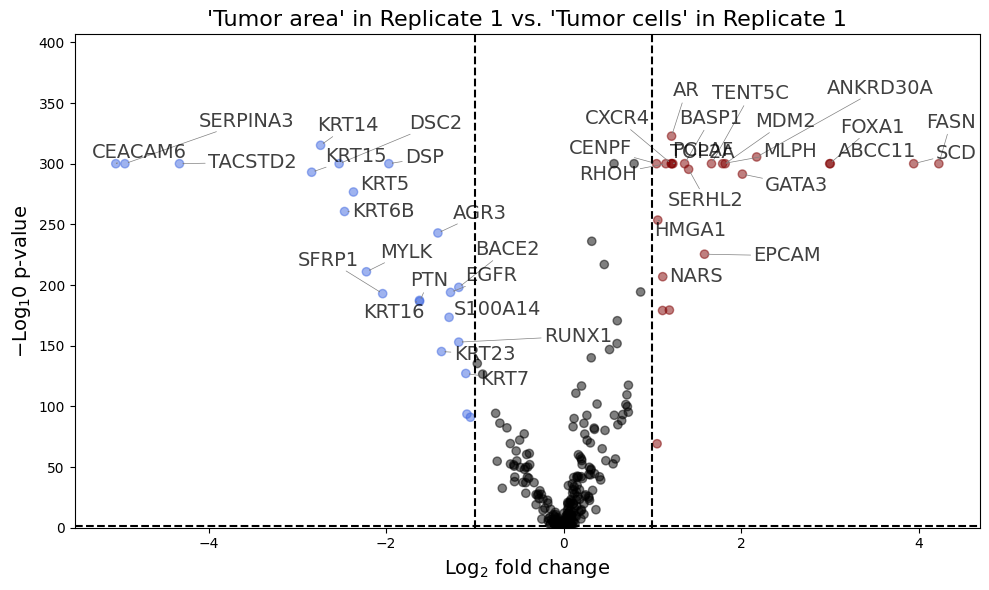

In [38]:
differential_gene_expression(
    data=xd,
    annotation_tuple=("Tumor", "Tumor area"),
    reference_tuple=("Tumor", "Tumor cells"),
    obs_tuple=("cell_type", "Breast cancer"),
    force_assignment=True,
    #region_key = "Tumor",
    #region_name = "Selected Tumor",
    #plot_volcano=True
)

Assigning key 'Tumor'...
Added results to `.cells.matrix.obsm[annotations]
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


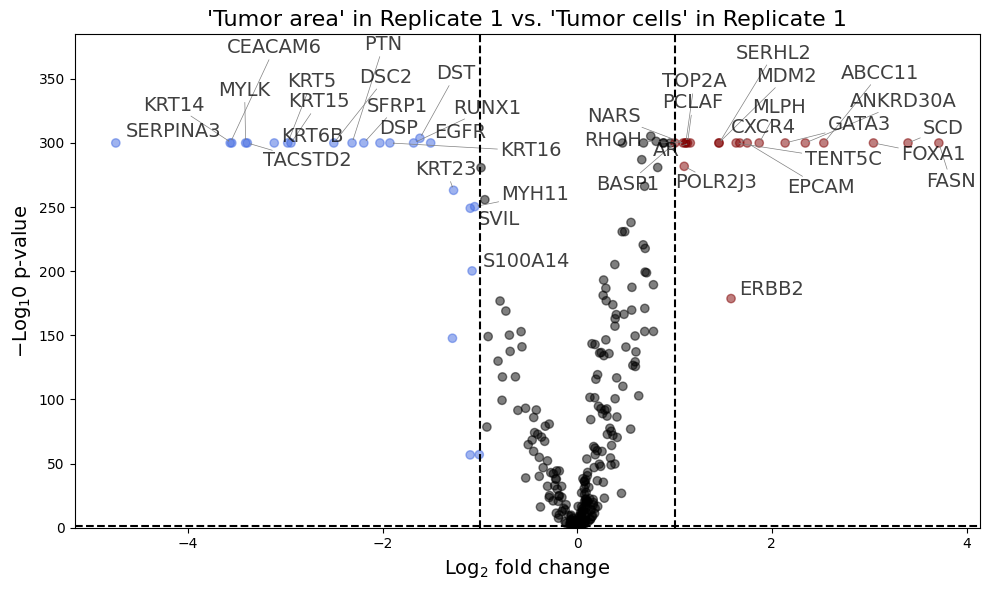

In [ ]:
differential_gene_expression(
    data=xd,
    annotation_tuple=("Tumor", "Tumor area"),
    reference_tuple=("Tumor", "Tumor cells"),
    force_assignment=True
    #region_key = "Tumor",
    #region_name = "Selected Tumor",
    #plot_volcano=True
)

In [37]:
xd.show()

Assigning key 'Tumor'...
Added results to `.cells.matrix.obsm[annotations]
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


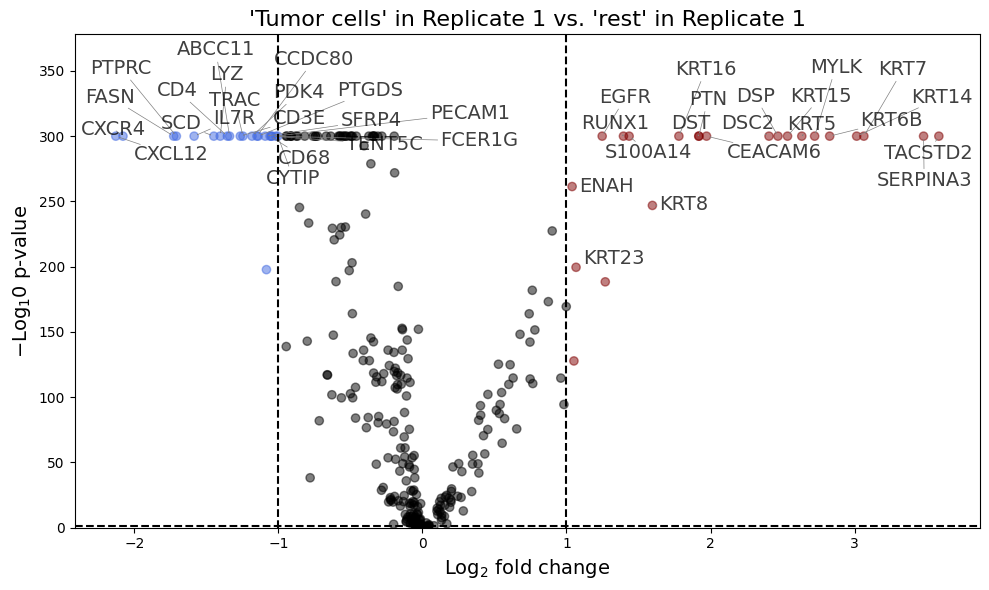

In [ ]:
differential_gene_expression(
    data=xd,
    annotation_tuple=("Tumor", "Tumor cells"),
    reference_tuple="rest",
    #region_key = "Tumor",
    #region_name = "Selected Tumor",
    #plot_volcano=True
)

Calculate differentially expressed genes using Scanpy's `rank_genes_groups`.


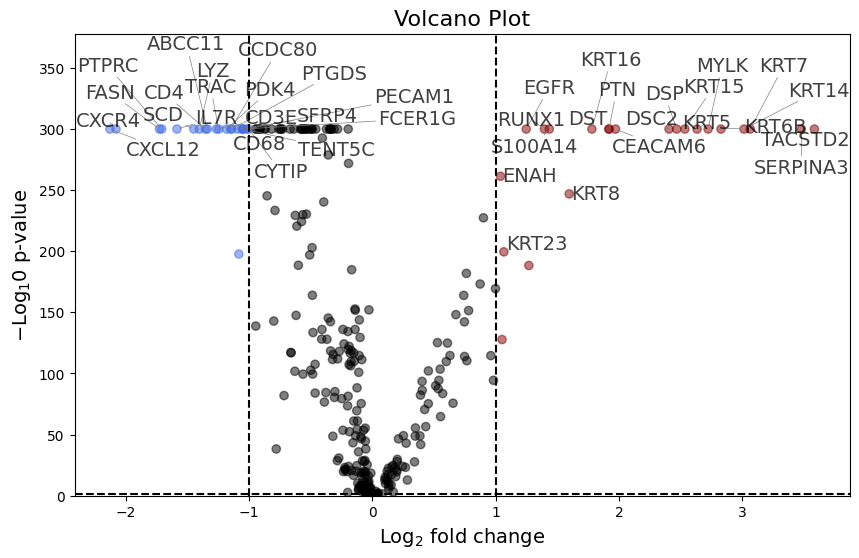

In [ ]:
differential_gene_expression(
    xd=xd,
    annotation_key = "Tumor",
    annotation_names = ["Tumor cells"],
    reference = "rest",
    region_key = "Tumor",
    region_name = "Selected Tumor",
    plot_volcano=True
)

In [ ]:
def differential_gene_expression(
    xd,
    annotation_key: str,
    annotation_names: str,
    region_key: str,
    region_name: str,
    reference: str = "rest",
    plot_volcano: bool = True
):
    key_added = "rank_genes_groups"
    groupby = f'annotations-{annotation_key}'

    print("Calculate differentially expressed genes using Scanpy's `rank_genes_groups`.")
    adata = sc.tl.rank_genes_groups(adata=xd.cells.matrix,
                            groupby=groupby,
                            groups=annotation_names,
                            reference=reference,
                            method="t-test",
                            key_added=key_added,
                            #key_added=f'{annotation_key}-{annotation_names}-{reference}',
                            copy=True
                            )

    # create dataframe from results
    df = create_deg_dataframe(
        adata=adata, groups=None,
    )

    if plot_volcano:
        volcano_plot(data=df["Tumor cells"])
    else:
        return df

In [76]:
df["Tumor cells"]

,gene,logfoldchanges,pvals,scores,neg_log10_pvals
0,SERPINA3,3.478838,1.000000e-300,76.203400,300.0
1,DSP,2.467960,1.000000e-300,73.796188,300.0
2,TACSTD2,3.584821,1.000000e-300,73.223534,300.0
3,DSC2,2.405922,1.000000e-300,65.861847,300.0
4,KRT7,3.064307,1.000000e-300,65.090866,300.0
...,...,...,...,...,...
308,CXCR4,-2.078571,1.000000e-300,-101.868324,300.0
309,SFRP4,-1.091191,1.000000e-300,-106.875519,300.0
310,CXCL12,-2.128300,1.000000e-300,-109.301224,300.0
311,IL7R,-1.584582,1.000000e-300,-125.543320,300.0


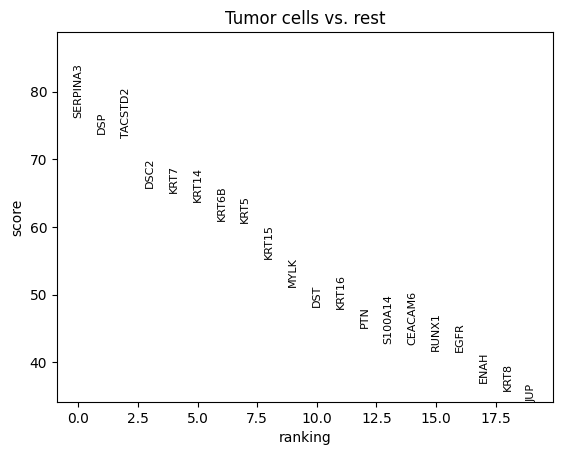

In [77]:
sc.pl.rank_genes_groups(adata)

In [30]:
res

{'params': {'groupby': 'annotations-Tumor',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('SERPINA3',), ('DSP',), ('TACSTD2',), ('DSC2',), ('KRT7',),
            ('KRT14',), ('KRT6B',), ('KRT5',), ('KRT15',), ('MYLK',),
            ('DST',), ('KRT16',), ('PTN',), ('S100A14',), ('CEACAM6',),
            ('RUNX1',), ('EGFR',), ('ENAH',), ('KRT8',), ('JUP',),
            ('KRT23',), ('SFRP1',), ('BACE2',), ('SVIL',), ('CDH1',),
            ('TRAPPC3',), ('FLNB',), ('C5orf46',), ('MYH11',), ('TCIM',),
            ('FOXC2',), ('AGR3',), ('CCND1',), ('CTTN',), ('GJB2',),
            ('KIT',), ('CLDN4',), ('TRIB1',), ('FSTL3',), ('ACTA2',),
            ('SLC5A6',), ('DMKN',), ('FBLIM1',), ('CCDC6',), ('CLCA2',),
            ('LYPD3',), ('TUBB2B',), ('ACTG2',), ('SLC25A37',), ('ELF5',),
            ('TPD52',), ('ADAM9',), ('C15orf48',), ('EDN1',), ('ELF3',),
            ('CXCL16',), ('CEACAM8',), 

In [22]:
xd.cells.matrix.uns["rank_genes_groups"]

{'params': {'groupby': 'annotations-Tumor',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('SERPINA3',), ('DSP',), ('TACSTD2',), ('DSC2',), ('KRT7',),
            ('KRT14',), ('KRT6B',), ('KRT5',), ('KRT15',), ('MYLK',),
            ('DST',), ('KRT16',), ('PTN',), ('S100A14',), ('CEACAM6',),
            ('RUNX1',), ('EGFR',), ('ENAH',), ('KRT8',), ('JUP',),
            ('KRT23',), ('SFRP1',), ('BACE2',), ('SVIL',), ('CDH1',),
            ('TRAPPC3',), ('FLNB',), ('C5orf46',), ('MYH11',), ('TCIM',),
            ('FOXC2',), ('AGR3',), ('CCND1',), ('CTTN',), ('GJB2',),
            ('KIT',), ('CLDN4',), ('TRIB1',), ('FSTL3',), ('ACTA2',),
            ('SLC5A6',), ('DMKN',), ('FBLIM1',), ('CCDC6',), ('CLCA2',),
            ('LYPD3',), ('TUBB2B',), ('ACTG2',), ('SLC25A37',), ('ELF5',),
            ('TPD52',), ('ADAM9',), ('C15orf48',), ('EDN1',), ('ELF3',),
            ('CXCL16',), ('CEACAM8',), 

In [16]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       DAPI:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 163565 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'annotations-TestKey', 'annotations-demo', 'annotations-demo2', 'annotations-demo3', 'cell_type', 'regions-Tumor', 'annotations-Tumor'
           var: 'gene_ids', 'feature_types', 'genome'
           uns: 'cell_type_colors', 'counts_location', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
           obsm: 'OT', 'X_pca', 'X_umap', 'spatial'
           varm: 'OT', 'PCs', 'binned_expression'
           layers: 'counts', 

In [18]:
s = xd.cells.matrix.obs["regions-Tumor"]
s[s.notna()]

4353      Selected Tumor
4356      Selected Tumor
4358      Selected Tumor
4359      Selected Tumor
4390      Selected Tumor
               ...      
118568    Selected Tumor
118569    Selected Tumor
118570    Selected Tumor
118575    Selected Tumor
118576    Selected Tumor
Name: regions-Tumor, Length: 22532, dtype: object

In [16]:
xd.cells.matrix.obs["dist_from_Tumor cells"]

1        NaN
2        NaN
5        NaN
8        NaN
9        NaN
          ..
167776   NaN
167777   NaN
167778   NaN
167779   NaN
167780   NaN
Name: dist_from_Tumor cells, Length: 163565, dtype: float64

In [17]:
xd.cells.matrix.obs["dist_from_Tumor cells"][xd.cells.matrix.obs["dist_from_Tumor cells"].notna()]

4353      125.378397
4356      124.466212
4358      113.188289
4359      116.878493
4390      131.468165
             ...    
118568     65.560087
118569     97.879879
118570     83.085464
118575     77.056102
118576    109.264239
Name: dist_from_Tumor cells, Length: 22532, dtype: float64

### Visualize the results using `napari`

Using `.show()` we can visualize the results and see the distance values per cell:
<center><img src="./demo_screenshots/distances_from_tumor_example.jpg" width="200"/></center>


In [18]:
xd.show()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


[autoreload of insitupy.plotting.expression_along_axis failed: Traceback (most recent call last):
  File "c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
  File "c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "C:\Users\ge37voy\Github\InSituPy\ins

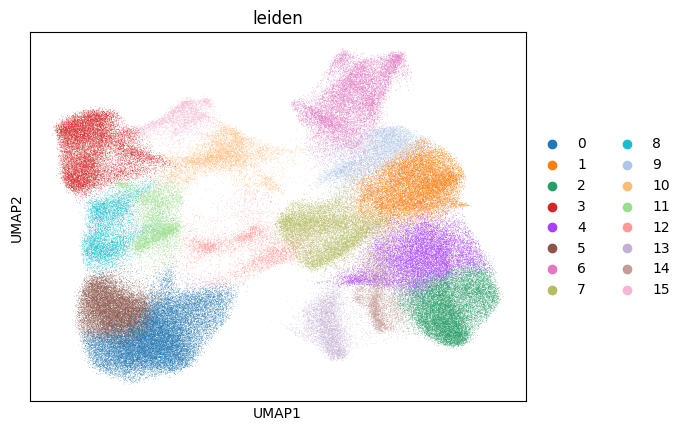

In [19]:
import scanpy as sc
sc.pl.umap(adata=xd.cells.matrix, color="leiden")

## Plot gene expression along axis

In [38]:
from insitupy.plotting import expr_along_obs_val, cell_abundance_along_obs_val

Key 'CD8' not found.


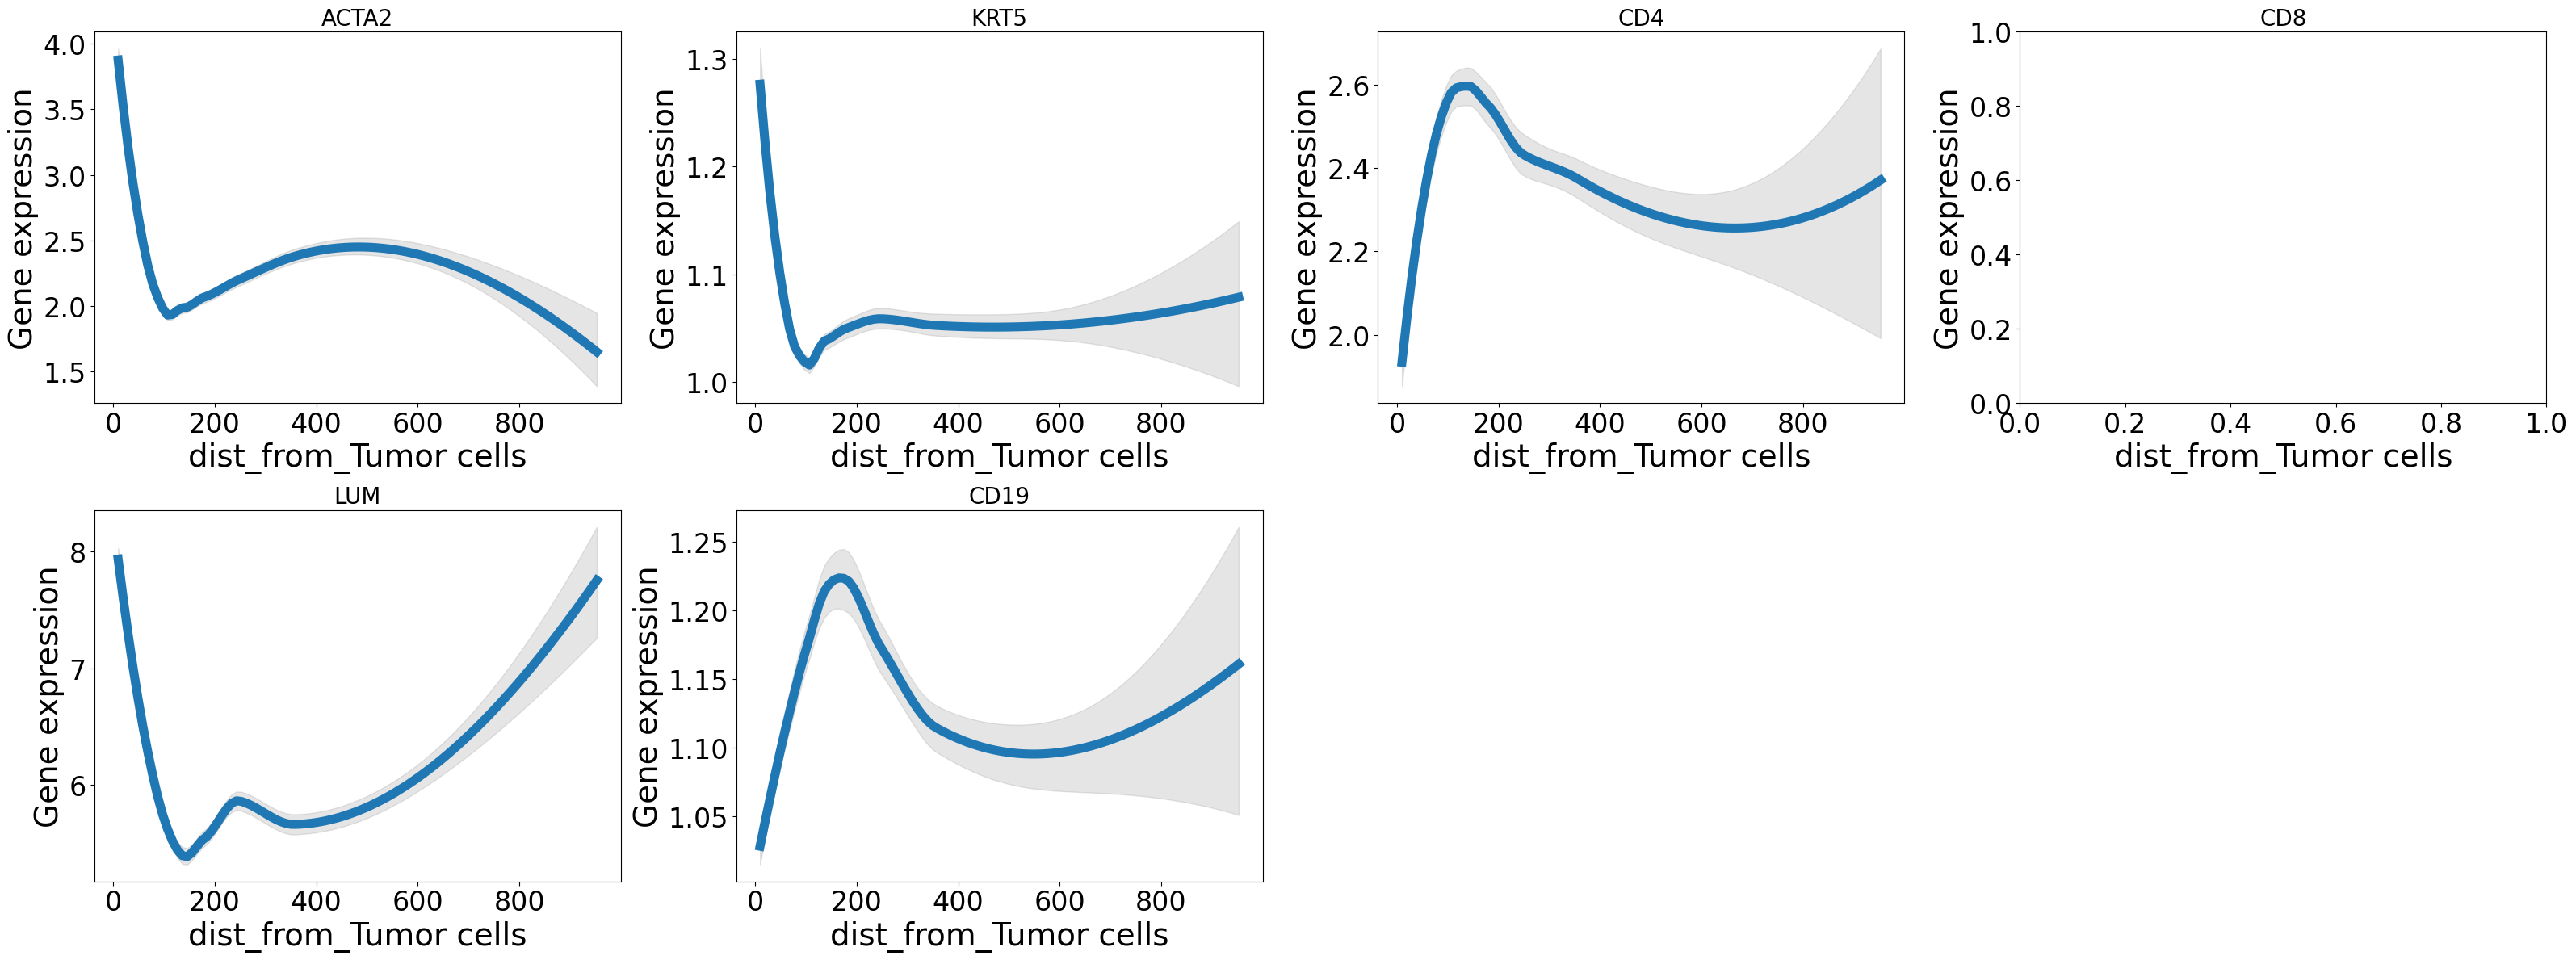

In [21]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=["ACTA2", "KRT5", "CD4", "CD8", "LUM", "CD19"],
                   obs_val="dist_from_Tumor cells",
                   stderr=True
                   )

## Plot abundance of cell types along axis

C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\expression_along_axis.py:422: UserWarning: The palette list has more values (20) than needed (18), which may not be intended.
  multiple="stack", element="bars",


Saving figure to file ./out/test.png
Saved.


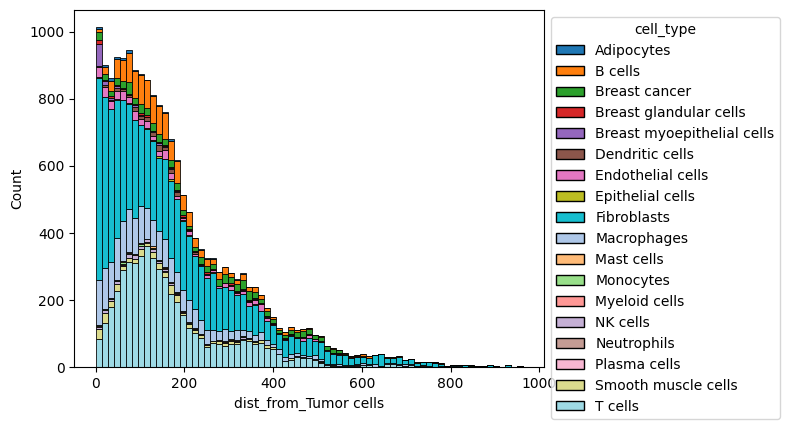

In [51]:
cell_abundance_along_obs_val(
    adata=xd.cells.matrix,
    obs_val="dist_from_Tumor cells",
    groupby="cell_type",
    figsize=(8,4.5)
)

In [56]:
xd.show()

In [28]:
x

1        NaN
2        NaN
5        NaN
8        NaN
9        NaN
          ..
167776   NaN
167777   NaN
167778   NaN
167779   NaN
167780   NaN
Name: dist_from_Tumor cells, Length: 163565, dtype: float64

## Groupby is possible but does not work if too little cells of a certain type are present

Key 'CD8' not found.


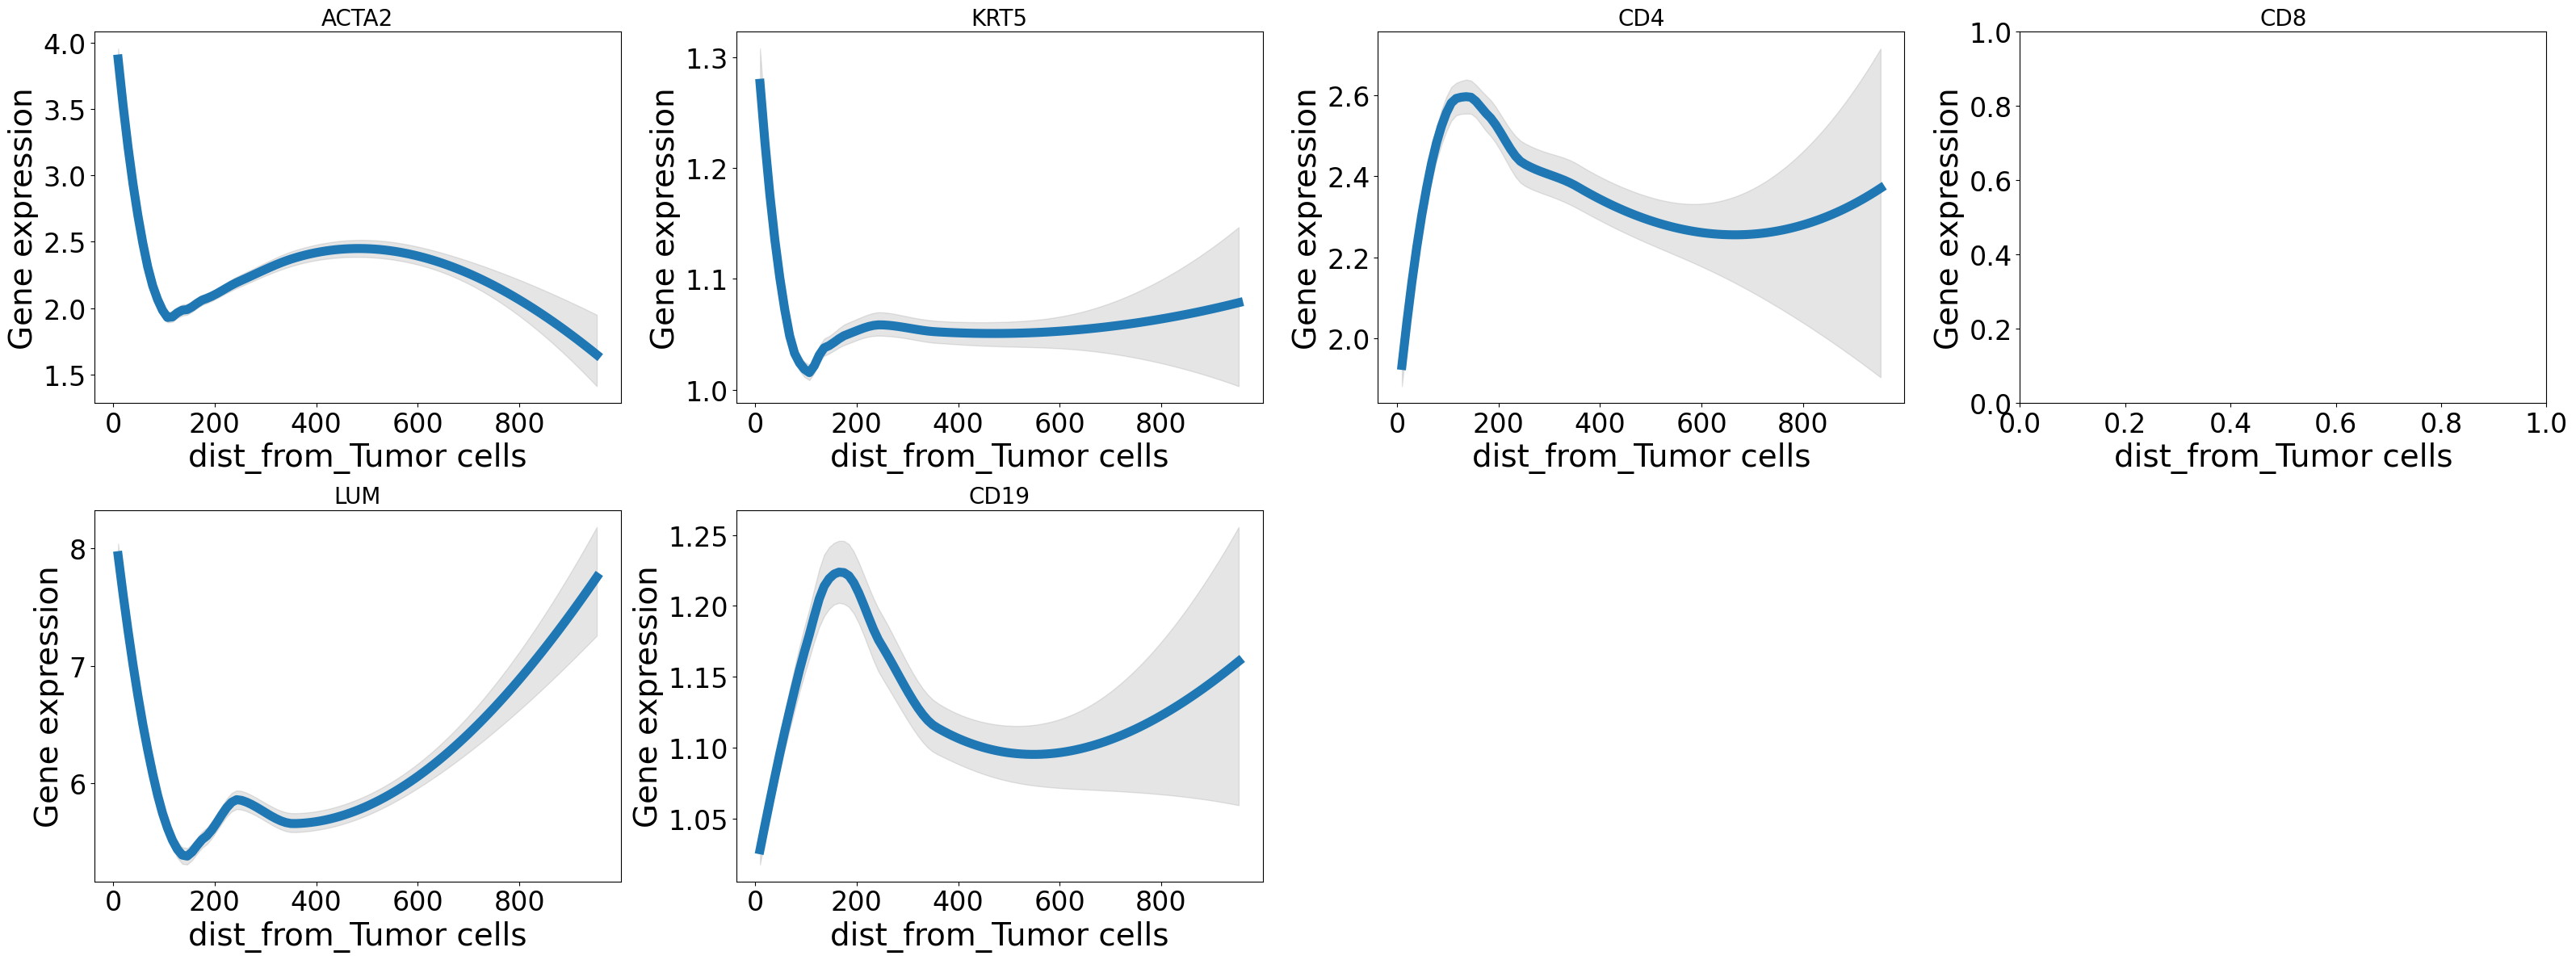

In [59]:
expr_along_obs_val(adata=xd.cells.matrix,
                   #groupby="leiden",
                   keys=["ACTA2", "KRT5", "CD4", "CD8", "LUM", "CD19"],
                   obs_val="dist_from_Tumor cells",
                   method="loess",
                   stderr=True
                   )

In [60]:
expr_along_obs_val(adata=xd.cells.matrix,
                   groupby="leiden",
                   keys=["ACTA2", "KRT5", "CD4", "CD8", "LUM", "CD19"],
                   obs_val="dist_from_Tumor cells",
                   method="loess",
                   stderr=True
                   )

: 

In [54]:
data = expr_along_obs_val(adata=xd.cells.matrix,
                   #groupby="leiden",
                   keys=["ACTA2", "KRT5", "CD4", "CD8", "LUM", "CD19"],
                   obs_val="dist_from_Tumor cells",
                   method="loess",
                   return_data=True,
                   #stderr=True
                   )

Key 'CD8' not found.


In [50]:
obs_val = "dist_from_Tumor cells"
adata_obs = xd.cells.matrix.obs
not_na_mask = adata_obs[obs_val].notna() & adata_obs[obs_val] > 0

In [51]:
not_na_mask.sum()

18171

In [52]:
adata_obs = adata_obs[not_na_mask]

In [53]:
adata_obs[obs_val].min()

0.011677935057340303

In [49]:
adata_obs[obs_val].notnull().sum()

22532

In [43]:
len(adata_obs)

22532

In [42]:
adata_obs[obs_val][adata_obs[obs_val] == 0]

6139      0.0
6142      0.0
6145      0.0
6146      0.0
6147      0.0
         ... 
118458    0.0
118498    0.0
118500    0.0
118501    0.0
118505    0.0
Name: dist_from_Tumor cells, Length: 4361, dtype: float64

In [34]:
data

x    y_pred    std
key                                       
ACTA2 None 0     9.719989  3.151033  False
           1    19.439979  2.980097  False
           2    29.159968  2.819161  False
           3    38.879958  2.668924  False
           4    48.599947  2.531426  False
...                   ...       ...    ...
CD19  None 93  913.679009  1.157196  False
           94  923.398998  1.160291  False
           95  933.118988  1.163459  False
           96  942.838977  1.166700  False
           97  952.558967  1.170014  False

[490 rows x 3 columns]